# Quantum singular value estimation

Ryan LaRose

### Abstract

Singular value decomposition is a powerful linear algebra technique. A quantum algorithm for estimating singular values, called quantum singular value estimation (QSVE), was presented in [1] for the purpose of recommendation systems. Later, it was shown how QSVE could be used as a subroutine for solving linear systems of equations [2]. In this notebook, we demonstrate how to use the Qiskit Aqua implementation of QSVE and explain how the algorithm works. In other notebooks, we present the applications to recommendation systems and linear systems in Qiskit Aqua.

In [1]:
"""Imports for the notebook."""
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

import qiskit
from qiskit.aqua.components.qsve import QSVE, BinaryTree

# Introduction

Although not all matrices can be diagonalized, every matrix has a singular value decomposition. If $A$ is an $m \times n$ matrix with complex entries, we can write

\begin{equation}
    A = U \Sigma V^\dagger 
\end{equation}

where $U \in \mathbb{C}^{m \times m}$ is unitary, $\Sigma \in \mathbb{R}^{m \times n}$ has non-negative diagonal components, and $V \in \mathbb{C}^{n \times n}$ is unitary. This can equivalently be written

\begin{equation}
    A = \sum_i \sigma_i \mathbf{u}_i \mathbf{v}_i^\dagger
\end{equation}

where $\sigma_i \ge 0$ are the diagonal elements (called _singular values_) of $\Sigma$, and $\mathbf{u}_i$ ($\mathbf{v}_i$) is the $i$th column vector (called _singular vectors_) of $U$ ($V$).

# Examples and usage

In this section, we present examples of how to use QSVE in Qiskit Aqua. We assume the input matrix is Hermitian without loss of generality. If this is not the case, the user is responsible for embedding the matrix into a Hermitian system, for example via the transformation

\begin{equation}
    A \longmapsto \left[ \begin{matrix}
                0 & A \\
                A^\dagger & 0 \\
                \end{matrix} \right] .
\end{equation}

For the simple examples in this notebook, we ensure Hermiticity by generating a matrix $A$ then transforming via $A \longmapsto A + A^\dagger$ if necessary.

### Example 1: Identity Matrix

Here we consider the simple case of estimating singular values of the identity matrix $I = \text{diag}(1, 1)$. This example is particularly suitable for QSVE because the matrix can be written

\begin{equation}
    I = \sqrt{2} \left[ \begin{matrix}
                \cos(0.25 * \pi) & 0 \\
                0 & \sin(0.25 * \pi) \\
                \end{matrix} \right]
\end{equation}

The angles $\theta = 0.25$ can be represented exactly as a binary fraction with a few qubits, so the QSVE algorithm is able to compute the singular values exactly. Note that we assume the singular values have been normalized by the Froebenius norm of the matrix. That is, we use QSVE to estimate $\sigma_j / ||A||_F$. 

In [2]:
"""Example of computing the singular values of the identity matrix."""
# Define the matrix of the system
matrix = np.identity(2)

# Get a QSVE instance
qsve = QSVE(matrix)

# Estimate and return the top singular values
qsigmas = qsve.top_singular_values()

# Compute the singular values classically for comparison
sigmas = qsve.singular_values_classical()

# Display the singular values
print("The singular values from QSVE are:", qsigmas)
print("The singular values from classical SVD are:", sigmas)

The singular values from QSVE are: [0.7071067811865476]
The singular values from classical SVD are: [0.70710678 0.70710678]


Here we see that the estimated singular values from QSVE are exactly the classically computed singular values, which are $1 / \sqrt{2}$ in closed form. 

Below, we can construct the circuit for QSVE and display the raw bitstring measurement outcomes.

In [3]:
"""Looking at the circuit and measurement outcomes of QSVE."""
# Create the circuit and run it to get the measurement outcomes
circuit = qsve.create_circuit(nprecision_bits=1, logical_barriers=True)
counts = qsve.run_and_return_counts()

# Display the circuit
print(circuit)
print("\nCounts =", counts)

                         ░ ┌───┐ ░                                         »
qpe_0: |0>───────────────░─┤ H ├─░────────────────────────────■────────────»
          ┌────────────┐ ░ └───┘ ░ ┌─────────────┐┌───┐┌───┐┌─┴─┐┌───┐┌───┐»
row_0: |0>┤ Ry(1.5708) ├─░───────░─┤ Ry(-1.5708) ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»
          └────────────┘ ░       ░ └─────────────┘└───┘└───┘└───┘└───┘└───┘»
col_0: |0>───────────────░───────░─────────────────────────────────────────»
                         ░       ░                                         »
«                                                              ░ ┌───┐ ░ 
«qpe_0: ───────────────────────────────■───────────────────────░─┤ H ├─░─
«       ┌────────────┐     ┌───┐┌───┐  │  ┌───┐┌───┐           ░ └───┘ ░ 
«row_0: ┤ Ry(1.5708) ├──■──┤ X ├┤ X ├──┼──┤ X ├┤ X ├───────■───░───────░─
«       └────────────┘┌─┴─┐├───┤├───┤┌─┴─┐└───┘├───┤┌───┐┌─┴─┐ ░       ░ 
«col_0: ──────────────┤ X ├┤ X ├┤ H ├┤ X ├─────┤ H ├┤ X ├┤ X ├─░───────░─
«                

We'll understand what the circuit is doing later in the notebook. For now, we explain how to convert from bitstrings to estimates of the singular values. (This is done automatically in the method `QSVE.top_singular_values` shown above.)

In [4]:
"""Converting bit strings to angles and singular values."""
# Measured bit strings from the above example
bitstring1 = "011"
bitstring2 = "010"

print("Measured bitstrings:")
print("bitstring1 =", bitstring1)
print("bitstring2 =", bitstring2)

# Convert these measured strings to floating point values
float1 = qsve.binary_decimal_to_float(bitstring1)
float2 = qsve.binary_decimal_to_float(bitstring2)

# Put the floating point angles in the interval [-1/2, 1/2]
theta1 = qsve.convert_measured(float1)
theta2 = qsve.convert_measured(float2)

print("\nBitstrings converted to angles in [-1/2, 1/2]:")
print("theta1 =", theta1)
print("theta2 =", theta2)

# Convert the angles to singular values
qsigma1 = qsve.angle_to_singular_value(theta1)
qsigma2 = qsve.angle_to_singular_value(theta2)

print("\nSingular values found via QSVE:")
print("qsigma1 = ", qsigma1)
print("qsigma2 = ", qsigma2)

Measured bitstrings:
bitstring1 = 011
bitstring2 = 010

Bitstrings converted to angles in [-1/2, 1/2]:
theta1 = -0.25
theta2 = 0.25

Singular values found via QSVE:
qsigma1 =  0.7071067811865476
qsigma2 =  0.7071067811865476


Since the measured bit strings of this unitary can be exactly expressed with three bits, we should not see any change as we go to $n > 3$ qubits for QPE. This is shown in the following cell.

In [5]:
"""Increasing the number of QPE qubits and checking the bit strings."""
for n in range(3, 7):
    counts = qsve.run_and_return_counts(nprecision_bits=n)
    print("Number of QPE qubits = {}, counts = {}".format(n, counts))

Number of QPE qubits = 3, counts = [('011', 5036), ('010', 4964)]
Number of QPE qubits = 4, counts = [('0011', 5036), ('0010', 4964)]
Number of QPE qubits = 5, counts = [('00011', 5036), ('00010', 4964)]
Number of QPE qubits = 6, counts = [('000011', 5036), ('000010', 4964)]


As can be seen, the bit strings do not change with more QPE qubits.

__Note__: The bit strings are "little endian," which means that the most significant bit is the last in the bit string.

### Example 2: Convergence towards singular values

In this example, we show how increasing the number of qubits used in QPE increases the accuracy of the singular value estimates. We first create a random two by two matrix, then use QSVE to estimate the top eigenvalue.

In [6]:
"""Example of convergence toward singular values."""
# Get a random matrix (seed for reproducibility)
np.random.seed(402457087)
matrix = np.random.randn(2, 2)
matrix += matrix.conj().T

# Get a QSVE instance and compute the singular values classically
qsve = QSVE(matrix)
print("Matrix:\n", np.round(qsve.matrix, 3))

sigmas = qsve.singular_values_classical()
print("Classical singular values:", np.round(sigmas, 5))
print("============================================")

nqubits = list(range(1, 7 + 1))
qsigmas = []
errors = []
theoretical_errors = []

for n in nqubits:
    print("Status: n =", n)
    qsigmas += qsve.top_singular_values(nprecision_bits=n, ntop=1)
    errors.append(abs(qsigmas[-1] - sigmas[0]))
    theoretical_errors.append(qsve.max_error(n))
    print("Current estimate:", np.round(qsigmas[-1], 5))

Matrix:
 [[-0.308 -0.169]
 [-0.169  0.195]]
Classical singular values: [0.8245  0.56587]
Status: n = 1
Current estimate: 1.0
Status: n = 2
Current estimate: 0.70711
Status: n = 3
Current estimate: 0.70711
Status: n = 4
Current estimate: 0.83147
Status: n = 5
Current estimate: 0.83147
Status: n = 6
Current estimate: 0.83147
Status: n = 7
Current estimate: 0.81758


The status messeges above show convergence to the singular value, which we can plot below. We also show the error in estimating the singular value.

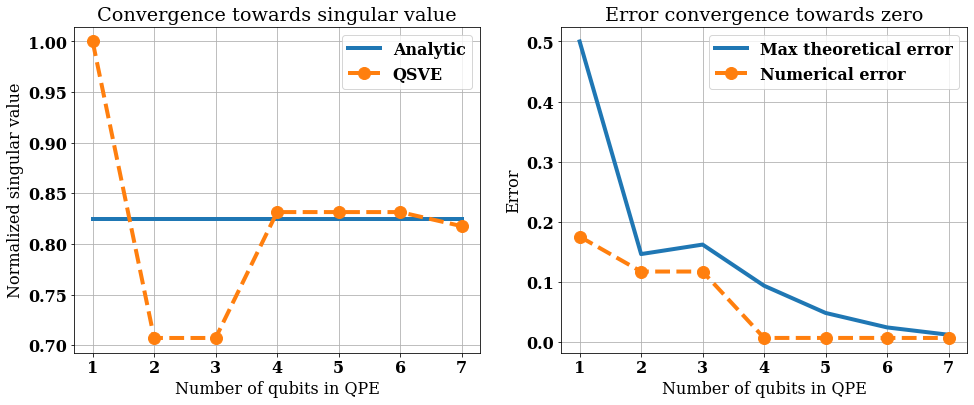

In [7]:
"""Plot the convergence to the singular value in the number of qubits for QPE."""
# Figure out which singular value was more prominent in the measurement statistics
ind = int(not np.isclose(qsigmas[-1], sigmas[0], atol=1e-2))

plt.rcParams.update({"font.size": 16, "font.family": "serif", "font.weight": "bold"})

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(nqubits, sigmas[ind] * np.ones(len(nqubits)), "-", linewidth=4, label="Analytic");
ax1.plot(nqubits, qsigmas, "--o", linewidth=4, markersize=12, label="QSVE");
ax1.set_xlabel("Number of qubits in QPE");
ax1.set_ylabel("Normalized singular value");
ax1.set_title("Convergence towards singular value");
ax1.grid();
ax1.legend();

ax2.plot(nqubits, theoretical_errors, "-", linewidth=4, label="Max theoretical error");
ax2.plot(nqubits, errors, "--o", linewidth=4, markersize=12, label="Numerical error");
ax2.set_xlabel("Number of qubits in QPE");
ax2.set_ylabel("Error");
ax2.set_title("Error convergence towards zero");
ax2.grid();
ax2.legend();

__Note__: The error plot assumes the top singular value is the largest one (i.e., the first in `sigmas`), which may not always be the case. If you change the matrix and the error does not seem to be going to zero, this is the reason. Simply change the `sigmas[0]` to `sigmas[1]` where the errors are computed to fix this.

Note that the simulation time quickly increases in the number of QPE qubits. For this example, going beyond seven qubits requires a longer time to execute, but with eight qubits the singular value estimate is accurate to five digits.

### Example 3: A larger matrix

Here we implement QSVE on an eight by eight sparse matrix. Below, we will see that the number of gates in the algorithm scales with the number of nonzero matrix elements, so we consider a sparse matrix here for efficiency.

In [8]:
"""Example: QSVE on a random sparse matrix."""
# Get a matrix and display it
sp = sparse.random(4, 4, density=0.3)
matrix = sp.toarray()
matrix += matrix.conj().T
print("Matrix:","=======", np.round(matrix, 3), sep="\n")

# Do the classical SVD and quantum SVE
ntop = 4
nbits = 5
qsve = QSVE(matrix)
sigmas = qsve.singular_values_classical()
print("\nClassically found singular values:", np.round(sigmas, 5))
qsigmas = qsve.top_singular_values(nprecision_bits=nbits, ntop=ntop)
print("\nTop {} quantum singular value estimates:".format(ntop), np.round(qsigmas, 5))

Matrix:
[[0.    0.    0.979 0.289]
 [0.    1.441 0.    0.   ]
 [0.979 0.    1.663 0.   ]
 [0.289 0.    0.    0.   ]]

Classically found singular values: [0.80658 0.54775 0.21801 0.04333]

Top 4 quantum singular value estimates: [0.19509 0.19509 0.      0.83147]


You should see that the quantum singular value estimates are close to one (or more) of the exact singular values. In particular, we can compute the maximum error $\epsilon_{\text{max}}$ on the singular value estimate  $\sigma_j^{\text{est}}$ for a given number of precision qubits. The top singular value estimate will be within this error from an exact singular value. That is,

\begin{equation}
    | \sigma_j^{\text{est}} - \sigma_j | \le \epsilon_{\text{max}}
\end{equation}


In [9]:
"""Print out the maximum erro rfor a given number of precision bits."""
print("Max error:", qsve.max_error(nbits))

Max error: 0.04853659084328378


You may also notice this example took a bit longer to run. We can understand why by inspecting the circuit below.

In [10]:
"""Example: Checking the number of gates in the circuit."""
circuit = qsve.create_circuit(nprecision_bits=nbits)
native = circuit.decompose()
print(native.count_ops())

{'u2': 134, 'u3': 2797, 'u1': 962, 'cx': 3248, 'h': 248, 'tdg': 372, 't': 496}


This circuit has on the order of $10^3$ to $10^4$ CNOT gates, and a comparable number of single qubit gates. These numbers quickly reach the capabilities of the simulators, and are far beyond the state of current quantum computers. QSVE is thus an algorithm for fault-tolerant quantum computers.

# How the algorithm works

The QSVE algorithm uses quantum phase estimation (QPE) on a particular unitary $W$, the eigenvalues of which are related to the singular values of the given matrix $A$. (Recall that QPE estimates eigenvalues of a unitary matrix.)

## Defining the unitary for QPE

To be concrete, let $A \in \mathbb{R}^{n \times n}$ be Hermitian with Froebenius norm $||A||_F$. To build up the unitary $W \in \mathbb{R}^{n^2 \times n^2}$, we define the isometry $M \in \mathbb{R}^{n^2 \times n}$ by

\begin{equation}
    M |i\rangle := \frac{1}{||\text{row}_i(A)||_2} |i\rangle \otimes |\text{row}_i(A)\rangle .
\end{equation}

In words, the $i$th column of $i$ (for $i = 1, ..., n$) is the $n^2$-dimensional vector $|i\rangle \otimes |\text{row}_i(A)\rangle$. We similarly define the isometry $N \in \mathbb{R}^{n \times n^2}$ as

\begin{equation}
    N |j\rangle := | \bar{A} \rangle \otimes |j\rangle \
\end{equation}

where $|\bar{A}\rangle$ is the vector of row norms of $A$, namely $|\bar{A} \rangle = [ ||\text{row}_1(A) ||_2, ..., ||\text{row}_n(A) ||_2]^T$. 

The unitary $W$ is then defined as

\begin{equation}
    W := (2 MM^\dagger - I)(2N N^\dagger - I)
\end{equation}

Note that $I$ denotes the identity operator and both terms in parentheses are reflection operators. 

It can be shown that the eigenvalues of $W$ are related to the singular values of $A$ [1]. In particular, suppose $e^{i \pi \theta_j}$ is an eigenvalue of $W$ where $\theta_j \in [-1, 1]$. Then, 

\begin{equation}
    \cos \pi \theta_j = \frac{\sigma_j}{||A||_F}
\end{equation}

Using QPE to compute the bit strings $\theta_j$ thus allows us to estimate the singular values of the desired matrix $A$. 

## Building the unitary in a quantum circuit

The key subroutine of QSVE is loading a vector onto a quantum state. This is known to be inefficient in general, which is why we require the matrix to be sparse. The `BinaryTree` data structure presented in [1] is a useful construction for loading a vector onto a quantum state.

### Loading a real vector onto a quantum state using a BinaryTree

Here we make a `BinaryTree` from the first row of a matrix, and print out the tree.

In [11]:
"""Example of using a BinaryTree to load amplitudes onto a quantum state."""
# Define a matrix
matrix = np.array([[0.6, 0.8],
                   [0.8, 0.6]])

# Get the first row vector of the matrix
row = matrix[0]

# Make a BinaryTree out of the row vector and display it
tree = BinaryTree(row)
print(tree)

    1.00    
0.36    0.64



The leaves of the tree store the squared vector elements. The parent value store the sum of these. We can use these to determine angles of rotation in order to load a quantum state proportional to this vector, as shown below.

In [12]:
"""Continued: Example of using a BinaryTree to load amplitudes onto a quantum state."""
# Define a quantum register and quantum circuit
qreg = qiskit.QuantumRegister(1)
circ = qiskit.QuantumCircuit(qreg)

tree.preparation_circuit(circ, qreg)
print(circ)

         ┌────────────┐
q0_0: |0>┤ Ry(1.8546) ├
         └────────────┘


We can check this rotation indeed prepares the desired vector `[0.6, 0.8]`, as shown below.

In [13]:
"""Continued: Example of using a BinaryTree to load amplitudes onto a quantum state."""
# Make sure the final state of the circuit is the initial vector (normalized)
simulator = qiskit.BasicAer.get_backend("unitary_simulator")
job = qiskit.execute(circ, simulator)

unitary = np.array(job.result().results[0].data.unitary)
state = np.real(unitary[:, 0])

print(f"Prepared state: {state}")

Prepared state: [0.6 0.8]


The `BinaryTree` works for loading a vector of any size (granted its a power of two) with positive or negative components, but they must be real valued. The number of gates scales with the number of non-zero vector components. An example of loading a four element vector onto two qubits is shown below.

In [19]:
"""Example of loading a vector of four elements using a BinaryTree."""
vector = np.random.randn(4)
tree = BinaryTree(vector)

qreg = qiskit.QuantumRegister(2)
circ = qiskit.QuantumCircuit(qreg)
tree.preparation_circuit(circ, qreg)

print(circ)

         ┌────────────┐┌───┐                  ┌───┐                 
q6_0: |0>┤ Ry(2.7724) ├┤ X ├────────■─────────┤ X ├────────■────────
         └────────────┘└───┘┌───────┴────────┐└───┘┌───────┴───────┐
q6_1: |0>───────────────────┤ U3(4.1728,0,0) ├─────┤ U3(3.311,0,0) ├
                            └────────────────┘     └───────────────┘


One can verify, as above, this indeed prepares the correct quantum state.

### Loading the rows and row norms of the matrix

When a matrix is input to a `QSVE` object, `BinaryTree`s are stored for each row of the matrix, and an additional `BinaryTree` is stored for a vector of all L2 row norms. This is shown in the cell below, using the same matrix as above.

In [20]:
"""QSVE objects store BinaryTrees for each row of the matrix, and the row norms of the matrix."""
matrix = np.array([[0.6, 0.8],
                   [0.8, 0.6]])
qsve = QSVE(matrix)

print("Tree for the first row:")
print(qsve.get_tree(0))

print("Tree for the second row:")
print(qsve.get_tree(1))

print("Tree for the row norms:")
print(qsve.row_norm_tree)

Tree for the first row:
    1.00    
0.36    0.64

Tree for the second row:
    1.00    
0.64    0.36

Tree for the row norms:
    2.00    
1.00    1.00



These `BinaryTree`s are used to implement the $M$ and $N$ isometries defined above. Specifically, the reflections $I - 2M M^\dagger$ and $I - 2N N^\dagger$ are implemented. The product of these is the unitary `W`. Since the unitary needs to be controlled on the qubit in the precision register for QPE, an optional argument allows the state preparation circuit to be controlled on an additional register.

In [21]:
"""Explanation of how the controlled-W unitary is implemented in the QSVE algorithm."""
# Get registers and a circuit
qpe_register = qiskit.QuantumRegister(1, name="qpe")
row_register = qiskit.QuantumRegister(1, name="row")
col_register = qiskit.QuantumRegister(1, name="col")
circ = qiskit.QuantumCircuit(qpe_register, row_register, col_register)

# Do the controlled row norm isometry. That is, the reflection I - 2 M M^\dagger
qsve.controlled_row_norm_reflection(circ, qpe_register[0], row_register)
circ.barrier()

# Do the controlled row isometry. That is, the reflection I - 2 N N^\dagger
qsve.controlled_row_reflection(circ, qpe_register[0], row_register, col_register)
circ.barrier()

print(circ)

                                                                 ░ »
qpe_0: |0>───────────────────────────■───────────────────────────░─»
          ┌─────────────┐┌───┐┌───┐┌─┴─┐┌───┐┌───┐┌────────────┐ ░ »
row_0: |0>┤ Ry(-1.5708) ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ Ry(1.5708) ├─░─»
          └─────────────┘└───┘└───┘└───┘└───┘└───┘└────────────┘ ░ »
col_0: |0>───────────────────────────────────────────────────────░─»
                                                                 ░ »
«                                                                          »
«qpe_0: ──────────────────────────────────────────────────────■────────────»
«                         ┌───┐                   ┌───┐┌───┐  │            »
«row_0: ────────■─────────┤ X ├─────────■─────────┤ X ├┤ X ├──┼────────────»
«       ┌───────┴────────┐└───┘┌────────┴────────┐├───┤├───┤┌─┴─┐┌───┐┌───┐»
«col_0: ┤ U3(-1.287,0,0) ├─────┤ U3(-1.8546,0,0) ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»
«       └────────────────┘     └─────────────────┘└───┘

This circuit should look similar to the one above for the identity matrix (but not exact). The `QSVE` class also contains methods to construct matrix representations of these isometries.

In [22]:
"""Use QSVE to visualize the row and row norm isometries."""
print("Row isometry (M):\n", qsve.row_isometry())
print("\nRow norm isometry (N):\n", qsve.norm_isometry())

Row isometry (M):
 [[0.6 0. ]
 [0.8 0. ]
 [0.  0.8]
 [0.  0.6]]

Row norm isometry (N):
 [[0.70710678 0.        ]
 [0.         0.70710678]
 [0.70710678 0.        ]
 [0.         0.70710678]]


The full QSVE algorithm consists of phase estimation with the unitary. It can be visualized for a specified number of QPE precision qubits below.

In [23]:
"""Do QPE with the unitary W."""
print("Matrix:\n", qsve.matrix)

print("\nQPE Circuit:\n", qsve.create_circuit(nprecision_bits=1, logical_barriers=True))

Matrix:
 [[0.6 0.8]
 [0.8 0.6]]

QPE Circuit:
                          ░ ┌───┐ ░                                         »
qpe_0: |0>───────────────░─┤ H ├─░────────────────────────────■────────────»
          ┌────────────┐ ░ └───┘ ░ ┌─────────────┐┌───┐┌───┐┌─┴─┐┌───┐┌───┐»
row_0: |0>┤ Ry(1.5708) ├─░───────░─┤ Ry(-1.5708) ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»
          └────────────┘ ░       ░ └─────────────┘└───┘└───┘└───┘└───┘└───┘»
col_0: |0>───────────────░───────░─────────────────────────────────────────»
                         ░       ░                                         »
«                                                                              »
«qpe_0: ────────────────────────────────────────────────────────────────────■──»
«       ┌────────────┐                  ┌───┐                   ┌───┐┌───┐  │  »
«row_0: ┤ Ry(1.5708) ├────────■─────────┤ X ├─────────■─────────┤ X ├┤ X ├──┼──»
«       └────────────┘┌───────┴────────┐└───┘┌────────┴────────┐├───┤├───┤┌─┴─┐»
«col_0: ─

The `logical_barriers` keyword argument places barriers between any initial state preparation; Hadamards on the QPE register; each implementation of $W$, $W^2$, $W^4$, etc.; and the inverse quantum Fourier transform.

# More examples and advanced usage

In this final section we present more examples and features of the `QSVE` class. 

### Example 4: Starting in a specified state

Any `QSVE` method implementing the controlled unitary (e.g., `QSVE.phase_estimation`, `QSVE.create_circuit`, and `QSVE.top_singular_values`) allows one to start in a specified state, as shown below. The user passes a vector (normalized or un-normalized) into the `singular_vector` keyword argument.

In [24]:
"""Example: Starting in a different state to estimate different singular values."""
matrix = np.random.randn(2, 2)
matrix += matrix.conj().T
qsve = QSVE(matrix)

classical = qsve.singular_values_classical()
print("Classically found (scaled) singular values:", np.round(classical, 4))
top_from_zero = qsve.top_singular_values(nprecision_bits=7, ntop=4, singular_vector=None)
print("Top singular values starting from |0>:", np.round(top_from_zero, 4))
top_from_one = qsve.top_singular_values(nprecision_bits=7, ntop=4, singular_vector=[0, 1, 0, 0])
print("Top singular values starting from |1>:", np.round(top_from_one, 4))

Classically found (scaled) singular values: [0.9906 0.1369]
Top singular values starting from |0>: [0.9892 0.9892 0.9925 0.9925]
Top singular values starting from |1>: [0.1467 0.1467 0.1224 0.1224]


You should see that different `singular_vector`s result in estimating different singular values with higher probability. (Recall: The top singular vectors returned from `QSVE.top_singular_values` are ordered by most probable to least probable.)

### Example 5: "Large" and sparse matrices

Here we implement QSVE for a $8 \times 8$ sparse matrix to estimate the singular values.

In [27]:
"""Example: QSVE on a 'large' and sparse matrix."""
det = 0.0
it = 0
maxit = 1000
while np.isclose(det, 0.0) and it < maxit:
    sp = sparse.random(8, 8, density=0.2)
    matrix = sp.toarray()
    matrix += matrix.conj().T
    det = np.linalg.det(matrix)
    it += 1

if np.isclose(det, 0.0):
    print("Failed to generate a non-singular Hermitian matrix with the given density.")
else:
    qsve = QSVE(matrix)

    classical = qsve.singular_values_classical()
    print("Classically found (scaled) singular values:", np.round(classical, 4))

    nbits = 4
    start = time.time()
    top = qsve.top_singular_values(nprecision_bits=nbits, ntop=4, singular_vector=None)
    runtime = time.time() - start

    print("Top singular values starting from |0>:", np.round(top, 4))
    print("Runtime:", round(runtime / 60, 3), "minutes.")

Classically found (scaled) singular values: [0.6425 0.4561 0.3883 0.3188 0.2374 0.1767 0.1609 0.1153]
Top singular values starting from |0>: [0.3827 0.3827 0.1951 0.1951]
Runtime: 3.855 minutes.


Below, we analyze the circuit used for QSVE.

In [28]:
"""Analyzing the QSVE circuit."""
circuit = qsve.create_circuit(nprecision_bits=nbits)
native = circuit.decompose()
print(native.count_ops())

{'u2': 3128, 'u3': 79059, 'u1': 22862, 'cx': 97848}


# Further Reading

TODO: Link to linear systems using QSVE and recommendation systems notebooks.

# References and notes

[1] I. Kerenidis and A. Prakash, “Quantum Recommendation Systems,”
        arXiv:1603.08675 [quant-ph], Mar. 2016.

[2] L. Wossnig, Z. Zhao, and A. Prakash, “A quantum linear system
    algorithm for dense matrices,” Phys. Rev. Lett., vol. 120, no. 5,
    p. 050502, Jan. 2018.

[3] There are $n^2$ eigenvalues of $W$, but there are only $n$ singular values of $A$. By symmetry of cosine about zero, exactly $2n$ eigenvalues of $W$ correspond to singular values of $A$. This means that there are $n^2 - 2n$ eigenvalues of $W$ _not_ related to singular values of $A$. What are these other eigenvalues? It can be easily seen that they are all one. While this does not affect the correctness of QSVE, it skews the measurement outcomes to contain a lot of all zero outcomes. This may be undesirable for large matrices. For the small examples we consider, however, this is not an issue.